# Use EN4 climatological volume of isopycnals to construct a density/pressure relationship used for remapping data from density to a pseudo-depth coordinate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from netCDF4 import Dataset as open_ncfile
import time

In [2]:
# Read EN4 file : will be our climatology

# # Read zonal volume
# indir = '/home/ericglod/Density_bining/test/'
# file = 'EN4.mon.ocean.Omon.1900_2017.density.nc'#'obs.EN4.historical.r0i0p0.mo.ocn.Omon.density.ver-1.latestX_zon2D.nc'
# f = open_ncfile(indir+file,'r')
# isonvol = np.ma.average(f.variables['isonvol'][:,:,:,:],axis=0)*1.e03 # Volume of isopycnals in km3, make climatology

# Or read global thickness of isopycnals and compute volume (because wrong zonal volume)
f = open_ncfile('/data/ericglod/Density_binning/Obs_Prod_density_april16/obs.EN4.historical.r0i0p0.mo.ocn.Omon.density.ver-1.latestX.nc')
thick = np.ma.average(f.variables['isonthickg'][:,:,:,:],axis=0)/1.e03
targetGrid = '/home/ysilvy/Density_bining/Yona_analysis/data/170224_WOD13_masks.nc'
# Target horizonal grid
gridFile_f  = open_ncfile(targetGrid,'r')
maskg       = gridFile_f.variables['basinmask3'][:]
areai = gridFile_f.variables['basinmask3_area'][:] #(latitude,longitude), in km2
Nii     = areai.shape[1]
Nji     = areai.shape[0]
N_s = thick.shape[0]
areaisig = np.tile(np.ma.reshape(areai,Nii*Nji), (N_s,1))
areaisig = np.ma.reshape(areaisig,[N_s,Nji,Nii])
maski       = maskg.mask ; # Global mask
# Regional masks
maskAtl = maski*1 ; maskAtl[...] = True
idxa = np.argwhere(maskg == 1).transpose()
maskAtl[idxa[0],idxa[1]] = False
maskPac = maski*1 ; maskPac[...] = True
idxp = np.argwhere(maskg == 2).transpose()
maskPac[idxp[0],idxp[1]] = False
maskInd = maski*1 ; maskInd[...] = True
idxi = np.argwhere(maskg == 3).transpose()
maskInd[idxi[0],idxi[1]] = False

# Compute total volume as thickness*area of each cell
volEN4 = thick*(1-(thick.mask).astype(int))*areaisig
print(np.ma.sum(volEN4)/1.e09) # In km3

# Mask with basin masks
thicki = thick*1.
thicki.mask = maski
thickia = thick*1.
thickia.mask = maskAtl
thickip = thick*1.
thickip.mask = maskPac
thickii = thick*1.
thickii.mask = maskInd
# Compute zonal volume
volz  = np.ma.sum(thicki *(1- (thicki.mask).astype(int))*areaisig, axis=2)
volza = np.ma.sum(thickia*(1- (thickia.mask).astype(int))*areaisig, axis=2)
volzp = np.ma.sum(thickip*(1- (thickip.mask).astype(int))*areaisig, axis=2)
volzi = np.ma.sum(thickii*(1- (thickii.mask).astype(int))*areaisig, axis=2)
print(np.ma.sum(volz)/1.e09)

# Read variables
lat = f.variables['latitude'][:]
density = f.variables['lev'][:]

basinN=4
latN = len(lat)
densityN = len(density)

# Regroup
# volz = np.ma.reshape(volz,(1,densityN,latN))
# volza = np.ma.reshape(volza,(1,densityN,latN))
# volzp = np.ma.reshape(volzp,(1,densityN,latN))
# volzi = np.ma.reshape(volzi,(1,densityN,latN))
# isonvol = np.ma.concatenate((volz,volza,volzp,volzi),axis=0)
isonvol = np.ma.stack([volz,volza,volzp,volzi],axis=0)
isonvol[isonvol==0]=np.ma.masked

1.3977086215200918
1.3977086215200916


In [3]:
gridz = np.arange(0,5501,5)
gridz2 = np.concatenate([np.arange(0,21,1),np.arange(25,5501,5)])

# WOA13 grid
targetz = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
   85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375,
   400, 425, 450, 475, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950,
   1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550,
   1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2100, 2200, 2300,
   2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500,
   3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700,
   4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500]

In [4]:
# Read bathymetry
# Read masks
fmask = open_ncfile('/home/ysilvy/Density_bining/Yona_analysis/data/170224_WOD13_masks.nc','r')
basinmask = fmask.variables['basinmask3'][:] # (latitude, longitude)
depthmask = fmask.variables['depthmask'][:] # (latitude, longitude)
longitude = fmask.variables['longitude'][:]
# Create basin masks
mask_a = basinmask != 1
mask_p = basinmask != 2
mask_i = basinmask != 3
# Read bathy
depthmask_a = np.ma.array(depthmask, mask=mask_a) # Mask every basin except Atlantic
depthmask_p = np.ma.array(depthmask, mask=mask_p)
depthmask_i = np.ma.array(depthmask, mask=mask_i)
# Zonal bathy (for plotting afterwards)
bathy_a = np.ma.max(depthmask_a, axis=1)
bathy_p = np.ma.max(depthmask_p, axis=1)
bathy_i = np.ma.max(depthmask_i, axis=1)
# Read area
area = fmask.variables['basinmask3_area'][:] # (latitude,longitude)

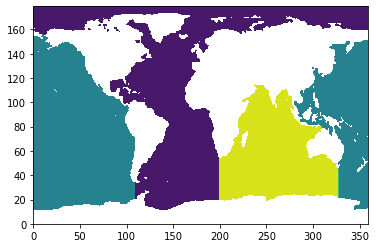

In [5]:
plt.contourf(basinmask)

In [6]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

## Start by calculating the theoretical volume of water in the ocean per depth level based on bathymetry - or read it if it has been saved

In [8]:
# Compute zonal volume on gridz2 levels (every 5 meters, every 1 meter at the surface)
V = np.ma.masked_all((basinN,len(gridz2),latN))
# Loop on Atlantic, Pacific and Indian basins
start_time = time.time()
for ibasin in range(1,4): 
    print(ibasin)
    if ibasin==1:
        depthmask = depthmask_a
    elif ibasin==2:
        depthmask = depthmask_p
    else:
        depthmask = depthmask_i
    for ilat in range(latN):
        area_lat = np.ma.average(area[ilat,:]) # Same area for all longitudes along ilat: take the average to make sure we don't choose a masked gridpoint
        # Loop on depths
        for iz in range(len(gridz2)):
            cells_above = np.argwhere(depthmask[ilat,:]>gridz2[iz]) #.squeeze() # list of indices where bathymetry is below the current z level
            if len(cells_above)!=0: #Exclude depths where there is no water
                S = len(cells_above)*area_lat # total area in km2 at depth gridz[iz] for the current band of latitude
                V[ibasin,iz,ilat] = S*0.001*(gridz2[iz+1]-gridz2[iz]) # Corresponding volume in km3 (5m interval for gridz, 1m at surface)

elapsed_time = time.time() - start_time

# Now compute volume for global zonal mean (ibasin=0)
V[0,:,:] = np.sum(V[1:,:,:],axis=0)

1
2
3


In [7]:
# Save theoretical volume
import pickle

# write to pickle
#pickle.dump( V, open( "/home/ysilvy/Density_bining/Yona_analysis/data/theoretical_volume_ocean.pkl", "wb" ) )

In [8]:
# read from pickle
V = pickle.load( open( "/home/ysilvy/Density_bining/Yona_analysis/data/theoretical_volume_ocean.pkl", "rb" ) )

## Here just running some tests

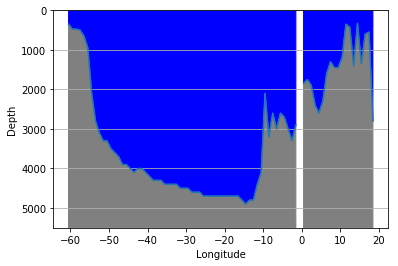

In [9]:
# Plot ocean for ibasin,ilat
ilat = 20
plt.plot(longitude,depthmask_a[ilat,:])
ax=plt.gca()
plt.ylim([0,5500])
plt.gca().invert_yaxis()
ax.fill_between(longitude,depthmask_a[ilat,:],color='blue')
ax.fill_between(longitude,depthmask_a[ilat,:],[5500]*len(longitude),color='grey')
plt.grid(axis='y')
plt.xlabel('Longitude')
plt.ylabel('Depth')
plt.show()
#depthmask_a[ilat,np.where(basinmask==1)]
#lat[ilat]

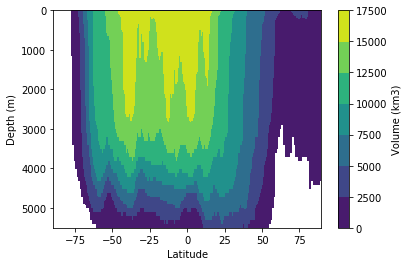

In [10]:
# Plot total volume
lat2d,z2d = np.meshgrid(lat,gridz2)
ax=plt.gca()
#ax.fill_between(lat,np.ma.max(depthmask_a,axis=1),[5500]*len(lat),color='grey')
plt.contourf(lat2d,z2d,V[0,:,:])
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
cb = plt.colorbar()
cb.set_label('Volume (km3)')
plt.show()

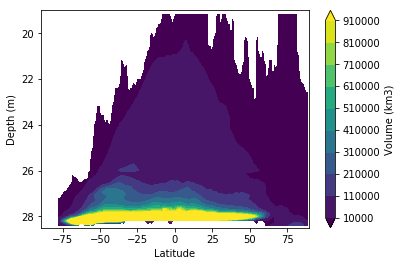

In [11]:
# Plot total volume of EN4 on isopycnals
lat2d,density2d = np.meshgrid(lat,density)
ax=plt.gca()
#ax.fill_between(lat,np.ma.max(depthmask_a,axis=1),[5500]*len(lat),color='grey')
plt.contourf(lat2d,density2d,isonvol[0,:,:],levels=np.arange(10000,1000000,100000),extend='both')
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
cb = plt.colorbar()
cb.set_label('Volume (km3)')
plt.show()

In [12]:
# Computed volume of the ocean, based on WOA13 bathymetry
np.sum(V[0,:,:])/1.e09 #*10^9km3

1.352102832608972

In [13]:
# EN4 volume of the ocean
np.ma.sum(isonvol[0,:,:])/1.e09 #*10^9km3

1.3977086215200916

In [14]:
# Model volume of the ocean
#indirh = '/data/ericglod/Density_binning/Prod_density_april15/mme_hist/'
indirh = '/data/ericglod/Density_binning/Prod_density_april15/historical/'
#fileh_2d = 'cmip5.CCSM4.historical.ensm.an.ocn.Omon.density.ver-v20121128_zon2D.nc' #'cmip5.CCSM4.historical.r1i1p1.an.ocn.Omon.density.ver-v20121128_zon2D.nc'#
fileh_2d = 'cmip5.IPSL-CM5A-LR.historical.r2i1p1.an.ocn.Omon.density.ver-v20111119_zon2D.nc'
fmod = open_ncfile(indirh+fileh_2d)
isonvol_mod = np.ma.average(fmod.variables['isonvol'][-100:,:,:,:],axis=0)*1.e03 # Volume of isopycnals in km3, make climatology
isonso = np.ma.average(fmod.variables['isonso'][-100:,:,:,:],axis=0)
np.ma.sum(isonvol_mod[0,:,:])/1.e09

1.6381679195148875

In [19]:
# Model volume of the ocean from 4D files
indir_raw = '/data/ericglod/Density_binning/Prod_density_april15/Raw/historical/correct/'
file_raw = 'cmip5.IPSL-CM5A-LR.historical.r2i1p1.an.ocn.Omon.density.ver-v20111119.nc'
fraw = open_ncfile(indir_raw+file_raw)
thick = np.ma.average(fraw.variables['isonthickg'][:,:,:,:],axis=0)/1.e03

In [20]:
# import sys
# sys.path.append("/home/ysilvy/Density_bining/")
targetGrid = '/home/ysilvy/Density_bining/Yona_analysis/data/170224_WOD13_masks.nc'
# Target horizonal grid
gridFile_f  = open_ncfile(targetGrid,'r')
maskg       = gridFile_f.variables['basinmask3'][:]
areai = gridFile_f.variables['basinmask3_area'][:] #(latitude,longitude), in km2
Nii     = areai.shape[1]
Nji     = areai.shape[0]
N_s = thick.shape[0]
areaisig = np.tile(np.ma.reshape(areai,Nii*Nji), (N_s,1))
areaisig = np.ma.reshape(areaisig,[N_s,Nji,Nii])
volraw = thick*(1-(thick.mask).astype(int))*areaisig

In [21]:
np.ma.sum(volraw)/1.e09 # In km3

1.2327514393249774

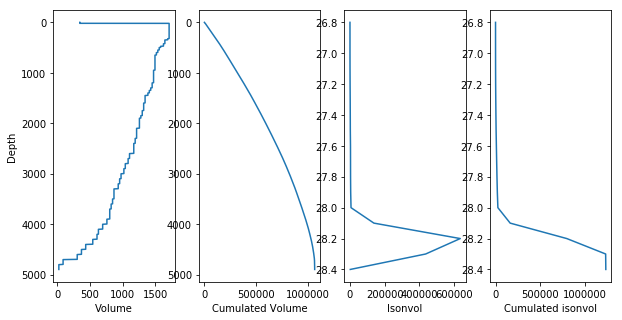

In [15]:
ibasin=1
cum_V = np.ma.cumsum(V[ibasin,:,ilat])
fig,ax = plt.subplots(1,4,figsize=(10,5))
ax[0].plot(V[ibasin,:,ilat],gridz2,label='Volume')
ax[0].set_xlabel('Volume')
ax[0].set_ylabel('Depth')
ax[0].invert_yaxis()
ax[1].plot(cum_V,gridz2,label='Cumulated Volume')
ax[1].set_xlabel('Cumulated Volume')
#ax[1].set_ylabel('Depth')
ax[1].invert_yaxis()
ax[2].plot(isonvol[ibasin,:,ilat],density)
ax[2].set_xlabel('Isonvol')
ax[2].invert_yaxis()
ax[3].plot(np.cumsum(isonvol[ibasin,:,ilat]),density)
ax[3].set_xlabel('Cumulated isonvol')
ax[3].invert_yaxis()
plt.subplots_adjust(hspace=0.2)
#plt.show()

# Plot difference between theoretical volume and EN4 isonvol for each water column

In [16]:
sum_V = np.sum(V,axis=1)
sum_isonvol = np.sum(isonvol,axis=1)
diff_sum = sum_V-sum_isonvol
diff_sum_pc = 100*(sum_isonvol-sum_V)/sum_V
ratio_wc = (sum_isonvol/sum_V)*100

In [10]:
sum_V.shape

(4, 180)

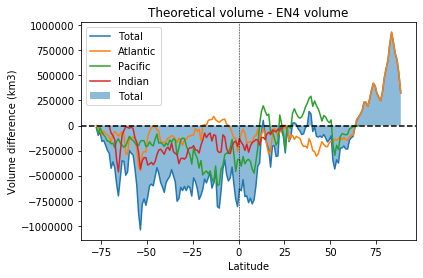

In [11]:
ax=plt.gca()
plt.plot(lat,diff_sum[0,:],label='Total')
plt.plot(lat,diff_sum[1,:],label='Atlantic')
plt.plot(lat,diff_sum[2,:],label='Pacific')
plt.plot(lat,diff_sum[3,:],label='Indian')
ax.axhline(y=0,ls='--',color='k')
ax.axvline(x=0,ls='--',color='k',lw=0.5)
ax.fill_between(lat,diff_sum[0,:],alpha=0.5,label='Total')
plt.xlabel('Latitude')
plt.ylabel('Volume difference (km3)')
plt.title('Theoretical volume - EN4 volume')
plt.legend()
#plt.show()
#plt.savefig('Volume_diff.pdf', bbox_inches='tight')

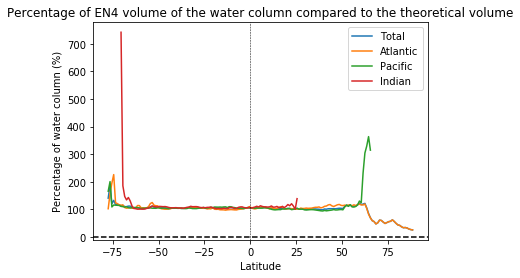

In [15]:
ax=plt.gca()
plt.plot(lat,ratio_wc[0,:],label='Total')
plt.plot(lat,ratio_wc[1,:],label='Atlantic')
plt.plot(lat,ratio_wc[2,:],label='Pacific')
plt.plot(lat,ratio_wc[3,:],label='Indian')
ax.axhline(y=0,ls='--',color='k')
ax.axvline(x=0,ls='--',color='k',lw=0.5)
plt.xlabel('Latitude')
plt.ylabel('Percentage of water column (%)')
#plt.ylim([-100,100])
plt.title('Percentage of EN4 volume of the water column compared to the theoretical volume')
plt.legend()
plt.savefig('Volume_pc_wc.pdf', bbox_inches='tight')

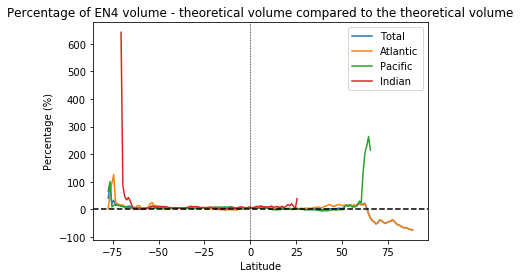

In [17]:
ax=plt.gca()
plt.plot(lat,diff_sum_pc[0,:],label='Total')
plt.plot(lat,diff_sum_pc[1,:],label='Atlantic')
plt.plot(lat,diff_sum_pc[2,:],label='Pacific')
plt.plot(lat,diff_sum_pc[3,:],label='Indian')
ax.axhline(y=0,ls='--',color='k')
ax.axvline(x=0,ls='--',color='k',lw=0.5)
plt.xlabel('Latitude')
plt.ylabel('Percentage (%)')
#plt.ylim([-100,100])
plt.title('Percentage of EN4 volume - theoretical volume compared to the theoretical volume')
plt.legend()
plt.savefig('Volume_diff_pc.pdf', bbox_inches='tight')

## Constructing remapping relationship pseudo_depth[basin,density,latitude] by re-filling the ocean from the surface down with horizontal layers of constant density

In [18]:
# Initialize
pseudo_depth = np.ma.masked_all((basinN,densityN,latN))
# Start loops
for ibasin in range(basinN):
    if ibasin==1:
        depthmask = depthmask_a
    elif ibasin==2:
        depthmask = depthmask_p
    elif ibasin==3:
        depthmask = depthmask_i
    for ilat in range(latN):
        if not np.ma.is_masked(np.all(isonvol[ibasin,:,ilat])):
            idx_range = np.ma.flatnotmasked_edges(isonvol[ibasin,:,ilat]) # Indices edges of unmasked densities in the column
            if ibasin==0: # For the whole ocean, take max depth
                bathy = np.ma.max([np.ma.max(depthmask_a[ilat,:]),np.ma.max(depthmask_p[ilat,:]),np.ma.max(depthmask_i[ilat,:])])
            else:
                bathy=np.ma.max(depthmask[ilat,:]) # Find max depth of the water column
            ibathy=np.argwhere(gridz2==bathy).squeeze() # Index of bathymetry = first masked value of the water column
            cum_V = np.cumsum(V[ibasin,:,ilat])
            cum_isonvol = np.cumsum(isonvol[ibasin,:,ilat])
            # Loop on density levels (stop one before the end)
            for ilev in range(idx_range[0],idx_range[1]):
                isonvol_lev = isonvol[ibasin,ilev,ilat]
                iz = find_nearest(cum_V,cum_isonvol[ilev])# Find index where the cumulated volume at ilev is closest to cumulated volume on gridz2
                pseudo_depth[ibasin,ilev,ilat] = gridz2[iz] # Save corresponding z level on gridz
            # Last density level: corresponds to bathy
            pseudo_depth[ibasin,idx_range[1],ilat] = bathy # TODO make sure this is correct
                #print(ilev,density[ilev],iz+1,gridz2[iz+1],cum_isonvol[ilev],cum_V[iz])

/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


## Save to output file

In [22]:
#import pickle

# write to pickle
#pickle.dump( pseudo_depth, open( "/home/ysilvy/Density_bining/Yona_analysis/data/remaptoz/EN4.pseudo_depth.zonal.pkl", "wb" ), protocol=2 )

# read from pickle
pseudo_z = pickle.load( open( "/home/ysilvy/Density_bining/Yona_analysis/data/remaptoz/EN4.pseudo_depth.zonal.pkl", "rb" ) )

In [15]:
pseudo_z = pseudo_depth

## Running tests

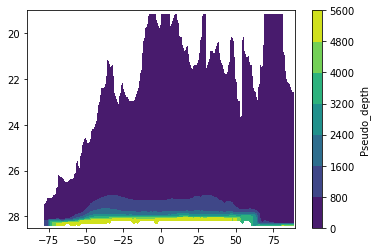

In [19]:
plt.contourf(lat2d,density2d,pseudo_z[1,:,:])
ax=plt.gca()
ax.invert_yaxis()
cb=plt.colorbar()
cb.set_label('Pseudo_depth')
plt.show()

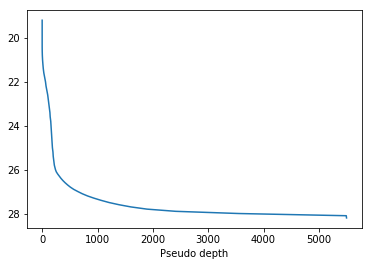

In [20]:
plt.plot(pseudo_z[0,:,90],density)
plt.gca().invert_yaxis()
plt.xlabel('Pseudo depth')
plt.show()

In [21]:
import sys
sys.path.append('/home/ysilvy/Density_bining/Yona_analysis/programs/')
from lib_remapping import remaptoz
from maps_matplot_lib import custom_div_cmap

In [22]:
var = fmod.variables['isonso'][:,:,:,:]
var_change = np.ma.average(var[-5:,:,:,:],axis=0)-np.ma.average(var[88:93,:,:,:],axis=0)

In [23]:
# Remap
fieldz=remaptoz(var_change,pseudo_z,targetz)

/home/ysilvy/.conda/envs/mypython3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


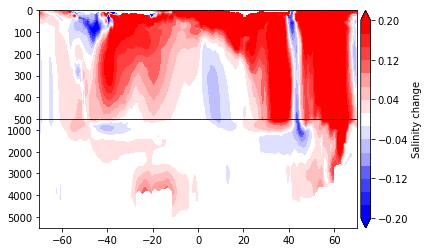

In [24]:
lat2d,targetz2d = np.meshgrid(lat,targetz)
cmap = custom_div_cmap()
levels=np.linspace(-0.2,0.2,16)
fig,ax = plt.subplots(2,1,sharex=True)
cnt0 = ax[0].contourf(lat2d,targetz2d,fieldz[1,:,:],cmap=cmap,levels=levels,extend='both')
ax[0].set_ylim([0,500])
ax[0].set_xlim([-70,70])
cnt1 = ax[1].contourf(lat2d,targetz2d,fieldz[1,:,:],cmap=cmap,levels=levels,extend='both')
ax[1].set_ylim([500,5500])
ax[0].invert_yaxis()
ax[1].invert_yaxis()
cb=plt.colorbar(cnt1,ax=ax.ravel().tolist(),ticks=levels[::3],fraction=0.04)
cb.set_label('Salinity change')
plt.subplots_adjust(hspace=0.001,right=0.86)
plt.show()

## Testing mean field remapping

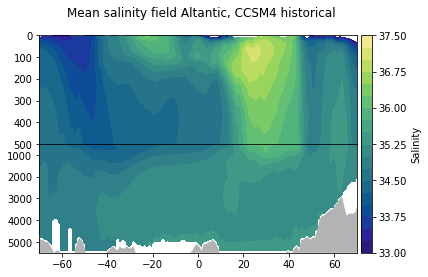

In [25]:
# CCSM4
import cmocean
# choose variable
fmod = open_ncfile('/data/ericglod/Density_binning/Prod_density_april15/mme_hist/cmip5.CCSM4.historical.ensm.an.ocn.Omon.density.ver-v20121128_zon2D.nc')
var = fmod.variables['isonso'][:,:,:,:]
var_mean = np.ma.average(var[-55:,:,:,:],axis=0)
var_mean_z = remaptoz(var_mean,pseudo_z,targetz)
fmod1d = open_ncfile('/data/ericglod/Density_binning/Prod_density_april15/mme_hist/cmip5.CCSM4.historical.ensm.an.ocn.Omon.density.ver-v20121128_zon1D.nc')
bowlz = np.ma.average(fmod1d.variables['ptopdepth'][-55:,:,:],axis=0)
# Plot
fig,ax = plt.subplots(2,1,sharex=True)
levels=np.arange(33, 37.6, .25)
cmap = cmocean.cm.haline
cnt0 = ax[0].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
#ax[0].plot(lat,bowlz[1,:],color='black', linewidth=2)
ax[0].set_ylim([0,500])
ax[0].set_xlim([-70,70])
cnt1 = ax[1].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
#ax[1].plot(lat,bowlz[1,:],color='black', linewidth=2)
bathy_a = np.ma.max(depthmask_a, axis=1)
ax[1].fill_between(lat,[targetz[-1]]*len(lat),bathy_a[:],facecolor='0.7')
ax[1].set_ylim([500,5500])
ax[0].invert_yaxis()
ax[1].invert_yaxis()
cb=plt.colorbar(cnt1,ax=ax.ravel().tolist(),ticks=levels[::3],fraction=0.04)
cb.set_label('Salinity')
plt.subplots_adjust(hspace=0.001,right=0.86)
plt.suptitle('Mean salinity field Altantic, CCSM4 historical')
plt.show()

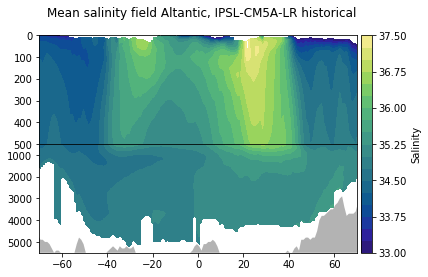

In [26]:
# IPSL-CM5A-LR
import cmocean
# choose variable
fipsl = open_ncfile('/data/ericglod/Density_binning/Prod_density_april15/mme_hist/cmip5.IPSL-CM5A-LR.historical.ensm.an.ocn.Omon.density.ver-v20111119_zon2D.nc')
var = fipsl.variables['isonso'][:,:,:,:]
var_mean = np.ma.average(var[-55:,:,:,:],axis=0)
var_mean_z = remaptoz(var_mean,pseudo_z,targetz)
fipsl1d = open_ncfile('/data/ericglod/Density_binning/Prod_density_april15/mme_hist/cmip5.IPSL-CM5A-LR.historical.ensm.an.ocn.Omon.density.ver-v20111119_zon1D.nc')
bowlz = np.ma.average(fipsl1d.variables['ptopdepth'][-55:,:,:],axis=0)
# Plot
fig,ax = plt.subplots(2,1,sharex=True)
levels=np.arange(33, 37.6, .25)
cmap = cmocean.cm.haline
cnt0 = ax[0].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
#ax[0].plot(lat,bowlz[1,:],color='black', linewidth=2)
ax[0].set_ylim([0,500])
ax[0].set_xlim([-70,70])
cnt1 = ax[1].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
#ax[1].plot(lat,bowlz[1,:],color='black', linewidth=2)
bathy_a = np.ma.max(depthmask_a, axis=1)
ax[1].fill_between(lat,[targetz[-1]]*len(lat),bathy_a[:],facecolor='0.7')
ax[1].set_ylim([500,5500])
ax[0].invert_yaxis()
ax[1].invert_yaxis()
cb=plt.colorbar(cnt1,ax=ax.ravel().tolist(),ticks=levels[::3],fraction=0.04)
cb.set_label('Salinity')
plt.subplots_adjust(hspace=0.001,right=0.86)
plt.suptitle('Mean salinity field Altantic, IPSL-CM5A-LR historical')
plt.show()

In [27]:
indirh

'/data/ericglod/Density_binning/Prod_density_april15/historical/'

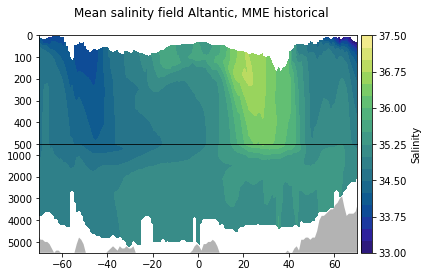

In [28]:
# Same with mme
# choose variable
fmme = open_ncfile('/data/ericglod/Density_binning/Prod_density_april15/mme_hist/cmip5.multimodel_Nat.historical.ensm.an.ocn.Omon.density_zon2D.nc')
var = fmme.variables['isonsoBowl'][:,:,:,:]
var_mean = np.ma.average(var[-55:,:,:,:],axis=0)
var_mean_z = remaptoz(var_mean,pseudo_z,targetz)
fmme1d = open_ncfile('/data/ericglod/Density_binning/Prod_density_april15/mme_hist/cmip5.multimodel_Nat.historical.ensm.an.ocn.Omon.density_zon1D.nc')
bowlz = np.ma.average(fmme1d.variables['ptopdepth'][-55:,:,:],axis=0)
# Plot
fig,ax = plt.subplots(2,1,sharex=True)
levels=np.arange(33, 37.6, .25)
cmap = cmocean.cm.haline
cnt0 = ax[0].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
#ax[0].plot(lat,bowlz[1,:],color='black', linewidth=2)
ax[0].set_ylim([0,500])
ax[0].set_xlim([-70,70])
cnt1 = ax[1].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
#ax[1].plot(lat,bowlz[1,:],color='black', linewidth=2)
bathy_a = np.ma.max(depthmask_a, axis=1)
ax[1].fill_between(lat,[targetz[-1]]*len(lat),bathy_a[:],facecolor='0.7')
ax[1].set_ylim([500,5500])
ax[0].invert_yaxis()
ax[1].invert_yaxis()
cb=plt.colorbar(cnt1,ax=ax.ravel().tolist(),ticks=levels[::3],fraction=0.04)
cb.set_label('Salinity')
plt.subplots_adjust(hspace=0.001,right=0.86)
plt.suptitle('Mean salinity field Altantic, MME historical')
plt.show()

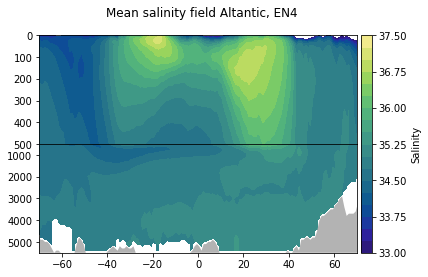

In [29]:
# Same with EN4
# choose variable
fEN4 = open_ncfile('/data/ericglod/Density_binning/Obs_Prod_density_april16/obs.EN4.historical.r0i0p0.mo.ocn.Omon.density.ver-1.latestX.nc')#/home/ericglod/Density_bining/test/EN4.mon.ocean.Omon.1900_2017.density.nc')
var = fEN4.variables['isonso'][:,:,:,:]
var_mean = np.ma.average(var[-68:-13:,:,:,:],axis=0)
bowlz = np.ma.average(fEN4.variables['ptopdepth'][-68:-13,:,:],axis=0)
bowlr = np.ma.average(fEN4.variables['ptopsigma'][-68:-13,:,:],axis=0)
# # Mask above bowl in rho
# for ilat in range(len(lat)):
#     if np.ma.is_masked(bowlr[1,ilat]) == False :
#         inda = np.ma.nonzero(bowlr[1,ilat]>=density)
#         var_mean[1,inda,ilat] = np.ma.masked
#     if np.ma.is_masked(bowlr[2,ilat]) == False :
#         indp = np.ma.nonzero(bowlr[2,ilat]>=density)
#         var_mean[2,indp,ilat] = np.ma.masked
#     if np.ma.is_masked(bowlr[3,ilat]) == False :
#         indi = np.ma.nonzero(bowlr[3,ilat]>=density)
#         var_mean[3,indi,ilat] = np.ma.masked
var_mean_z = remaptoz(var_mean,pseudo_z,targetz)
# Plot
fig,ax = plt.subplots(2,1,sharex=True)
levels=np.arange(33, 37.6, .25)
cmap = cmocean.cm.haline
cnt0 = ax[0].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
#ax[0].plot(lat,bowlz[1,:],color='black', linewidth=2)
ax[0].set_ylim([0,500])
ax[0].set_xlim([-70,70])
cnt1 = ax[1].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
#ax[1].plot(lat,bowlz[1,:],color='black', linewidth=2)
bathy_a = np.ma.max(depthmask_a, axis=1)
ax[1].fill_between(lat,[targetz[-1]]*len(lat),bathy_a[:],facecolor='0.7')
ax[1].set_ylim([500,5500])
ax[0].invert_yaxis()
ax[1].invert_yaxis()
cb=plt.colorbar(cnt1,ax=ax.ravel().tolist(),ticks=levels[::3],fraction=0.04)
cb.set_label('Salinity')
plt.subplots_adjust(hspace=0.001,right=0.86)
plt.suptitle('Mean salinity field Altantic, EN4')
plt.show()

In [23]:
# Remap ToE IPSL r2i1p1
indirr = '/home/ysilvy/Density_bining/Yona_analysis/data/toe_zonal/toe_rcp85_histNat/'
filerho = 'cmip5.IPSL-CM5A-LR.toe_zonal_rcp_histNat.nc'
frho = open_ncfile(indirr+filerho,'r')
toerho = frho.variables['isonsoToE2'][2,:,:,:] + 1860 # index 2 (3rd position) corresponds to run r2i1p1 (ls -U order)
var_change = frho.variables['isonso_change'][2,:,:,:]
toerho.fill_value = 1.e20
idx = np.argwhere(var_change.mask==True)
toerho[idx[:,0],idx[:,1],idx[:,2]] = np.ma.masked

In [18]:
# If remap with grid z with 31 levels
indirz = '/home/ysilvy/Density_bining/Yona_analysis/data/toe_zonal_z/toe_rcp85_histNat/'
filez = 'cmip5.IPSL-CM5A-LR.r2i1p1.Salinity_toe_zonal_rcp_histNat.nc'
fz = open_ncfile(indirz+filez,'r')
targetz2 = fz.variables['depth'][:].data

In [29]:
targetz2

array([4.9999380e+00, 1.5000288e+01, 2.5001759e+01, 3.5005413e+01,
       4.5013317e+01, 5.5029499e+01, 6.5061806e+01, 7.5125511e+01,
       8.5250366e+01, 9.5494286e+01, 1.0596992e+02, 1.1689624e+02,
       1.2869791e+02, 1.4219525e+02, 1.5896062e+02, 1.8196278e+02,
       2.1664792e+02, 2.7247672e+02, 3.6430304e+02, 5.1153476e+02,
       7.3220087e+02, 1.0332173e+03, 1.4056975e+03, 1.8308850e+03,
       2.2897678e+03, 2.7682424e+03, 3.2574788e+03, 3.7524421e+03,
       4.2504014e+03, 4.7499131e+03, 5.2502266e+03], dtype=float32)

In [30]:
# Remap toerho to z
toerhotoz = remaptoz(toerho,pseudo_z,targetz2)

In [31]:
# -- Make variable bundles for each basin
varAtlrhoz = {'name': 'Atlantic', 'var_change': toerhotoz[1,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': None, 'density':None}
varPacrhoz = {'name': 'Pacific', 'var_change': toerhotoz[2,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': None, 'density':None}
varIndrhoz = {'name': 'Indian', 'var_change': toerhotoz[3,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': None, 'density':None}

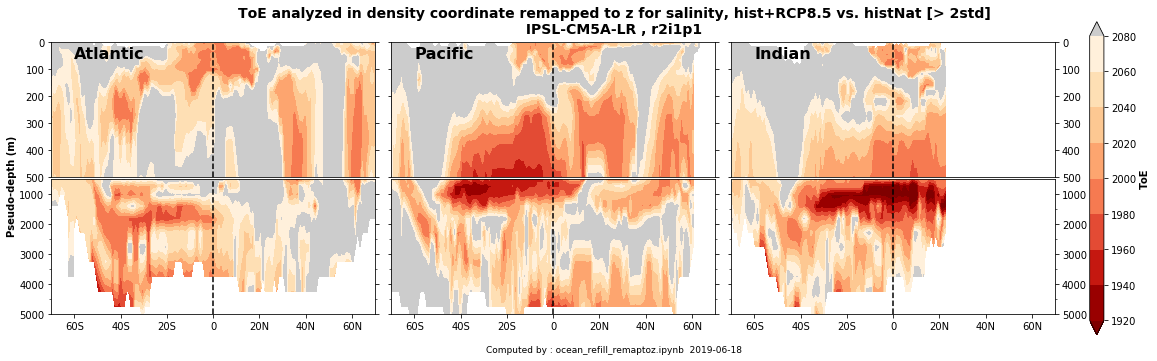

In [32]:
from maps_matplot_lib import zon_2Dz
import datetime
# -- Create figure and axes instances
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 5))

deltat=20
minyear=1920
domzed = [0,500,5000]
# -- Color map
cmap = 'OrRd_r'
# -- Unit
unit = 'ToE'
# -- Levels
minmax = [minyear, 2080.01, deltat]
levels = np.arange(minmax[0], minmax[1], minmax[2])
ext_cmap = 'both'
# -- Put everything into a dictionary
contourDict = {'cmap':cmap, 'levels':levels, 'levels2':levels, 'ext_cmap':ext_cmap, 'isopyc':False}

# -- Contourf
# Atlantic
cnplot = zon_2Dz(plt, axes[0,0], axes[1,0], 'left', lat, targetz2, varAtlrhoz,
                  contourDict, domzed, None, None)
cnplot[0].cmap.set_over('0.8')
cnplot[1].cmap.set_over('0.8')

# -- Add colorbar
cb = fig.colorbar(cnplot[1], ax=axes.ravel().tolist(), ticks=levels, fraction=0.015, shrink=2.0, pad=0.05)
cb.set_label('%s' % (unit,), fontweight='bold')

# Pacific
cnplot = zon_2Dz(plt, axes[0,1], axes[1,1], 'mid', lat, targetz2, varPacrhoz,
                  contourDict, domzed, None, None)
cnplot[0].cmap.set_over('0.8')
cnplot[1].cmap.set_over('0.8')

# Indian
cnplot = zon_2Dz(plt, axes[0,2], axes[1,2], 'right', lat, targetz2, varIndrhoz,
                  contourDict, domzed, None, None)
cnplot[0].cmap.set_over('0.8')
cnplot[1].cmap.set_over('0.8')

plt.subplots_adjust(hspace=.01, wspace=0.05, left=0.04, right=0.86)


# -- Add title
plotTitle = 'ToE analyzed in density coordinate remapped to z for salinity, hist+RCP8.5 vs. histNat [> 2std]' \
    '\n %s , %s '%('IPSL-CM5A-LR','r2i1p1')

plt.suptitle(plotTitle, fontweight='bold', fontsize=14, verticalalignment='top')

# Date
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

plt.figtext(.5,.02,'Computed by : ocean_refill_remaptoz.ipynb  '+date,fontsize=9,ha='center')
plt.figtext(.004,.6,'Pseudo-depth (m)',rotation='vertical',fontweight='bold')

figureDir = 'models/ToE_z_analysis/'
plotName = 'toeS_gammatoz_EN4_31levels_IPSL_r2i1p1_rcp85vshistNat'
plt.savefig('/home/ysilvy/figures/'+figureDir+plotName+'.pdf', bbox_inches='tight')

In [26]:
len(targetz)

102